In [1]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from bs4 import BeautifulSoup
import urllib
from string import ascii_lowercase
from nltk.stem import WordNetLemmatizer
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets
import operator
import pattern.en as en
from bs4 import BeautifulSoup
import urllib2
import matplotlib.pyplot as plt
from collections import Counter
from string import ascii_lowercase
import unicodedata
import nltk
import re
from nltk.stem import PorterStemmer
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities
import heapq

In [2]:
#Code to scrape BBC food ingredients
#BBC ingredients are used to standardize the ingredients in Yummly recipe dataset.

ingredients_raw = []
for alpha in ascii_lowercase:
    if alpha != 'x':
      file = urllib2.urlopen('http://www.bbc.co.uk/food/ingredients/by/letter/'+ alpha)
      soup = BeautifulSoup(file, "lxml")
      tag = soup.find('div', 'page')
      ol_tag = tag.find('ol', { "class" : "resources foods grid-view" })
      atags = ol_tag.find_all('li')
      for atag in atags:
         raw = atag.get('id')
         for letter in raw:
            if letter == "_":
                raw = raw.replace(letter," ")
         ingredients_raw.append(raw)


In [3]:
#Add Pluralized bbc ingredients in order to catch ingredients like tomatoes, carrots, etc
ingredients_plural = [en.pluralize(i) for i in ingredients_raw]
ingredients_raw = ingredients_raw + ingredients_plural

In [4]:
#Get ingredient list from the combined json file
train = pd.read_json('allrecipes.json')
train.ingredientLines.head()

0    [2 cups Baby Bella mushrooms, sliced, 2 cups a...
1    [2.5 lb pork country style ribs, all fat trimm...
2    [2 whole garlic heads, 2 tablespoons plus 2 te...
3    [1 garlic clove, halved, Cooking spray, 6 peel...
4    [1 pound lean ground beef, 1 tablespoon Worces...
Name: ingredientLines, dtype: object

In [5]:
#Clean recipe function to get tokenize all ingredients using nltk library & standardizing them with bbc food data
#nltk.download()

ps = PorterStemmer()

def clean_ingr(ingredients):
   
    ingr = [x.encode('UTF8') for x in ingredients] 
    tokens = nltk.word_tokenize(str(ingr))
    token_lower = [str.lower(i) for i in tokens]
    pairs = [ " ".join(pair) for pair in nltk.bigrams(token_lower)]
    clean_pairs = [i for i in pairs if i in ingredients_raw]
    pairs_joined = []
    for i in ingr:
        joined_str = re.sub('('+'|'.join('\\b'+re.escape(g)+'\\b' for g in clean_pairs)+')',lambda m: m.group(0).replace(' ', '_'),i)
        pairs_joined.append(joined_str)
    #print pairs_joined
    tokens = nltk.word_tokenize(str(pairs_joined))
    token_lower = [str.lower(i) for i in tokens]
    clean_tokens = [i for i in token_lower if i in ingredients_raw] 
    clean_ingr = clean_tokens + clean_pairs
    #print clean_ingr
    return clean_ingr

In [6]:
#Test clean_ingr function for first ingredient
clean_ingr(train.ingredientLines[0])

['mushrooms',
 'butter',
 'shallots',
 'fat',
 'pepper',
 'pepper',
 'parsley',
 'arborio rice',
 'olive oil',
 'white wine',
 'chicken stock',
 'vegetable stock',
 'parmesan cheese']

In [7]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [ Counter(clean_ingr(ingredients)) for ingredients in train.ingredientLines ]

In [8]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'ingredient', 0:'count'})
clean_df.to_csv('ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [8]:
clean_df

,ingredient,count
0,chillis,2
1,red cabbage,136
2,pheasant,2
3,dijon mustard,1203
4,mixed nuts,7
5,macadamia nuts,21
6,smoked fish,1
7,mackerel,7
8,ale,19
9,courgettes,10


In [9]:
ingr_only_dict = clean_df['ingredient'].to_dict()

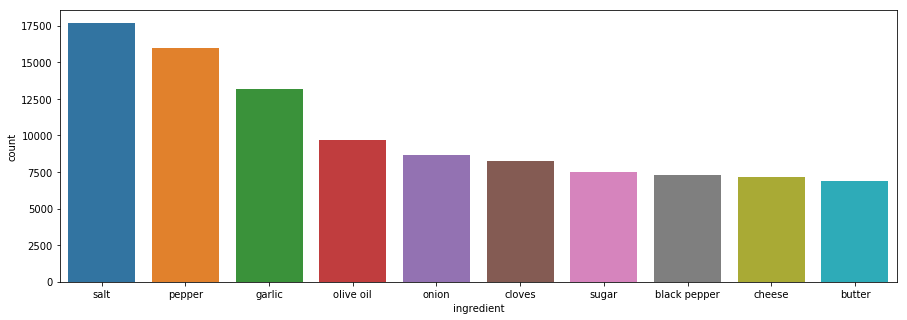

In [10]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'ingredient', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [11]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for ingredients in train.ingredientLines:
    ingr_list.append(clean_ingr(ingredients))

In [ ]:
print ingr_list[0]

In [12]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [13]:
print l[0]

['butter', 'mushrooms']


In [14]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [15]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print df.count()

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print df.count()

Ingredient1    3090783
Ingredient2    3090783
dtype: int64
Ingredient1    2989278
Ingredient2    2989278
dtype: int64


In [16]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    2989278
Ingredient2    2989278
f_x            2989278
f_y            2989278
f_xy           2989278
pmi            2989278
dtype: int64


In [ ]:
df

In [17]:
#Eliminate rows for the same ingredient combinations
print df.pmi.count()
df = df.drop_duplicates()
print df.pmi.count()

#Sort df
df = df.sort_values('pmi',ascending='false')
df.head()

2989278
90025


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
624152,broth,vanilla extract,65959,20982,1,-6.137666
624040,chicken,vanilla extract,70795,20982,2,-5.515274
629548,onions,vanilla extract,29712,20982,1,-5.340184
2808228,black beans,vanilla extract,23631,20982,1,-5.111192
101431,black pepper,vanilla extract,118038,20982,5,-5.110202


In [50]:
df = pd.read_csv('pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('pmi_ingredient_similarity_neg.csv')

In [18]:
top_df.to_csv('pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [36]:
temp = df[(df['I1'] == 'eel') | (df['I2'] == 'eel') ]
temp

,I1,I2,f_x,f_y,f_xy,pmi
1105550,eel,sauce,7,89676,1,1.560674
1105545,eel,shrimp,7,13803,1,3.431991
1105534,eel,lemon,7,13781,1,3.433586
1105553,eel,rice vinegar,7,3998,1,4.671083
1105552,eel,sesame seeds,7,3543,1,4.791903
1105527,cucumber,eel,6593,1,1,6.116779
1105551,eel,sushi rice,7,60,1,8.870288
1105540,eel,nori,7,38,1,9.327046


In [39]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [13]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Ingredient':ingr_list})
#print ingr_clean_df
print ingr_clean_df
ingr_clean_df.to_csv('ingredient_2_recipe_clean.csv')

                                              Ingredient
0      [mushrooms, butter, shallots, fat, pepper, pep...
1      [pork, fat, vinegar, lemon, cloves, garlic, pe...
2      [garlic, madeira, porcini, mushrooms, onion, m...
3      [garlic, potatoes, butter, salt, cheese, milk,...
4      [beef, sauce, garlic, salt, worcestershire sau...
5      [turkey, spice, carrot, celery, onion, lemon, ...
6      [beef, sauce, lemon, garlic, salt, pepper, but...
7      [sugar, liqueur, cherries, almonds, cream, sal...
8      [bread, bread, cheese, egg, garlic, salt, pepp...
9      [chicken, onions, celery, almonds, watercress,...
10     [vinegar, mustard, salt, pepper, salt, pepper,...
11     [shrimp, butter, flour, onion, pepper, celery,...
12     [onion, garlic, cloves, tomato, tomatoes, suga...
13     [sage, pepper, salt, eggs, sage, egg white, ol...
14     [pork, stock, ginger, cloves, garlic, salt, pe...
15     [butter, salt, pepper, salt, pepper, macaroni,...
16     [salad, oil, onion, garl

In [32]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other

num_features = 300   # Word vector dimensionality                      
context = 1        # Context window size; 
downsampling = 1e-3   # threshold for configuring which higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(ingr_list, size=num_features, window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [15]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [108]:
flatten_list

['mushrooms',
 'butter',
 'shallots',
 'fat',
 'pepper',
 'parsley',
 'arborio rice',
 'olive oil',
 'white wine',
 'chicken stock',
 'vegetable stock',
 'parmesan cheese',
 'pork',
 'vinegar',
 'lemon',
 'cloves',
 'garlic',
 'soy sauce',
 'brown sugar',
 'black pepper',
 'madeira',
 'porcini',
 'onion',
 'rice',
 'cheese',
 'salt',
 'sage',
 'shiitake mushroom',
 'potatoes',
 'milk',
 'beef',
 'sauce',
 'worcestershire sauce',
 'turkey',
 'spice',
 'carrot',
 'celery',
 'maple syrup',
 'safflower oil',
 'sugar',
 'liqueur',
 'cherries',
 'almonds',
 'cream',
 'egg whites',
 'bread',
 'egg',
 'onions',
 'tomatoes',
 'oregano',
 'turkey breast',
 'chicken',
 'watercress',
 'wild rice',
 'mustard',
 'carrots',
 'orange juice',
 'dijon mustard',
 'shrimp',
 'flour',
 'broth',
 'seasoning',
 'tomato',
 'long-grain rice',
 'basil',
 'lamb',
 'beef mince',
 'wholemeal bread',
 'eggs',
 'egg white',
 'mozzarella cheese',
 'stock',
 'ginger',
 'chilli',
 'honey',
 'pork belly',
 'rice wine',


In [16]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.most_similar(i)})      
    except KeyError:
        pass

In [127]:
corpus_sim_dict

{'acorn squash': [('stilton cheese', 0.9815765619277954),
  ('split peas', 0.9775859117507935),
  ('lamb chops', 0.9775597453117371),
  ('pink peppercorns', 0.9748415946960449),
  ('lamb shanks', 0.9725455045700073),
  ('chilli paste', 0.9702343940734863),
  ('cavolo nero', 0.966813862323761),
  ('duck confit', 0.9662741422653198),
  ('horseradish sauce', 0.9654864072799683),
  ('bouquet garni', 0.965189516544342)],
 'acorn squashes': [('foie gras', 0.9834803342819214),
  ('flaked almonds', 0.9818520545959473),
  ('wild mushroom', 0.9802365899085999),
  ('pork chop', 0.9744576215744019),
  ('dessicated coconut', 0.9744461178779602),
  ('beef consomme', 0.9739456176757812),
  ('sunflower seed', 0.9728331565856934),
  ('biscotti', 0.9724645018577576),
  ('mixed nuts', 0.9707936644554138),
  ('dried fruit', 0.9702429175376892)],
 'ale': [('gingerbread', 0.9441007375717163),
  ('blueberry', 0.9375195503234863),
  ('lager', 0.9360606670379639),
  ('tangerine', 0.9355812072753906),
  ('peels

In [17]:
sim_df = pd.DataFrame([])
for key,value in corpus_sim_dict.iteritems():
    for i in value:
        sim_df = sim_df.append(pd.DataFrame({'Similar Ingredient':i[0],'Word2Vec Value': i[1],'Ingredient': key }, index=[0]), ignore_index=True)

In [137]:
sim_df.head()

,Ingredient,Similar Ingredient,Word2Vec Value
0,mixed nuts,wild mushroom,0.988452
1,mixed nuts,pork chop,0.986329
2,mixed nuts,beef consomme,0.984315
3,mixed nuts,dessicated coconut,0.978431
4,mixed nuts,jerk seasoning,0.977989


Compress the word vectors into 2D space and plot them

In [36]:
word2vecTSNE = word2vec.Word2Vec(
    sg=1,
    size=num_features, window = context, sample = downsampling,
    min_count=3
)
word2vecTSNE.build_vocab(ingr_list)

In [40]:
word2vecTSNE.train(ingr_list,total_examples= word2vecTSNE.corpus_count, epochs=word2vecTSNE.iter)

1012350

In [41]:
if not os.path.exists("trained"):
    os.makedirs("trained")
word2vecTSNE.save(os.path.join("trained", "word2vecTSNE.w2v"))
word2vecTSNE = word2vec.Word2Vec.load(os.path.join("trained", "word2vecTSNE.w2v"))

In [42]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [43]:
all_word_vectors_matrix = word2vecTSNE.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [48]:
#Plot the big picture

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vecTSNE.wv.vocab[word].index])
            for word in word2vecTSNE.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)


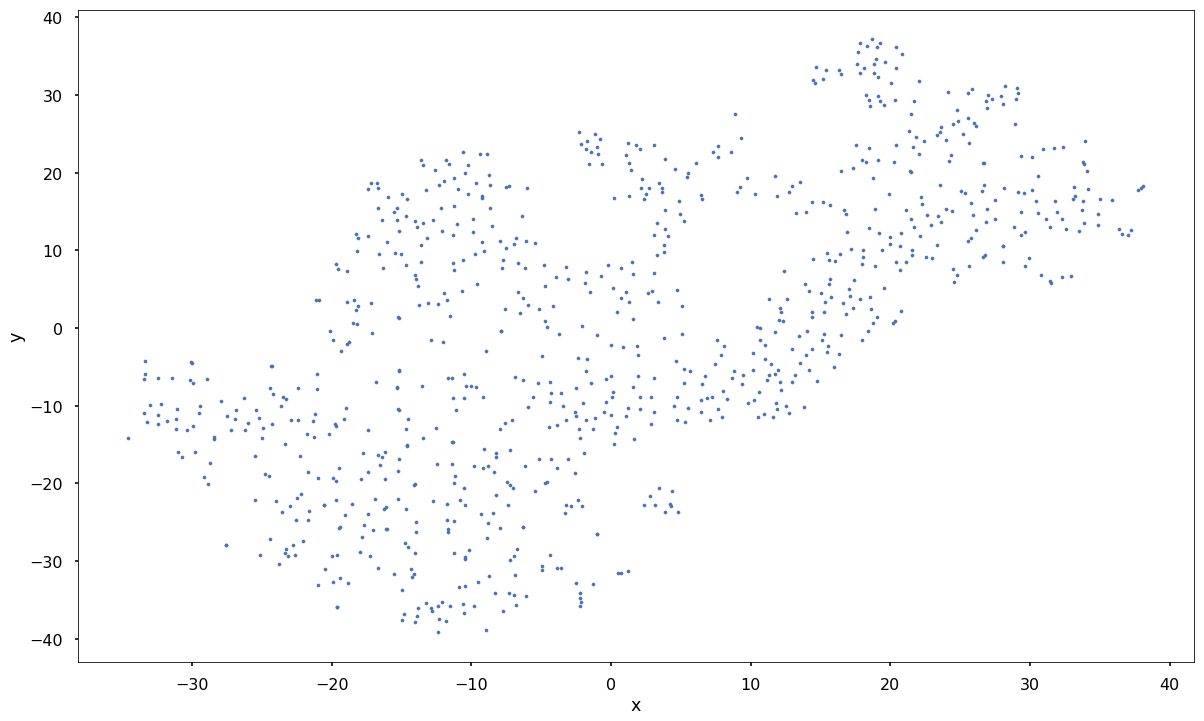

In [53]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

In [96]:
#Zoom in to some interesting places


def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(100, 80))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [99]:
points.head(10)
points.to_csv('word2vec_tse.csv')

In [97]:
plot_region(x_bounds=(-40,40), y_bounds=(-40, 40))

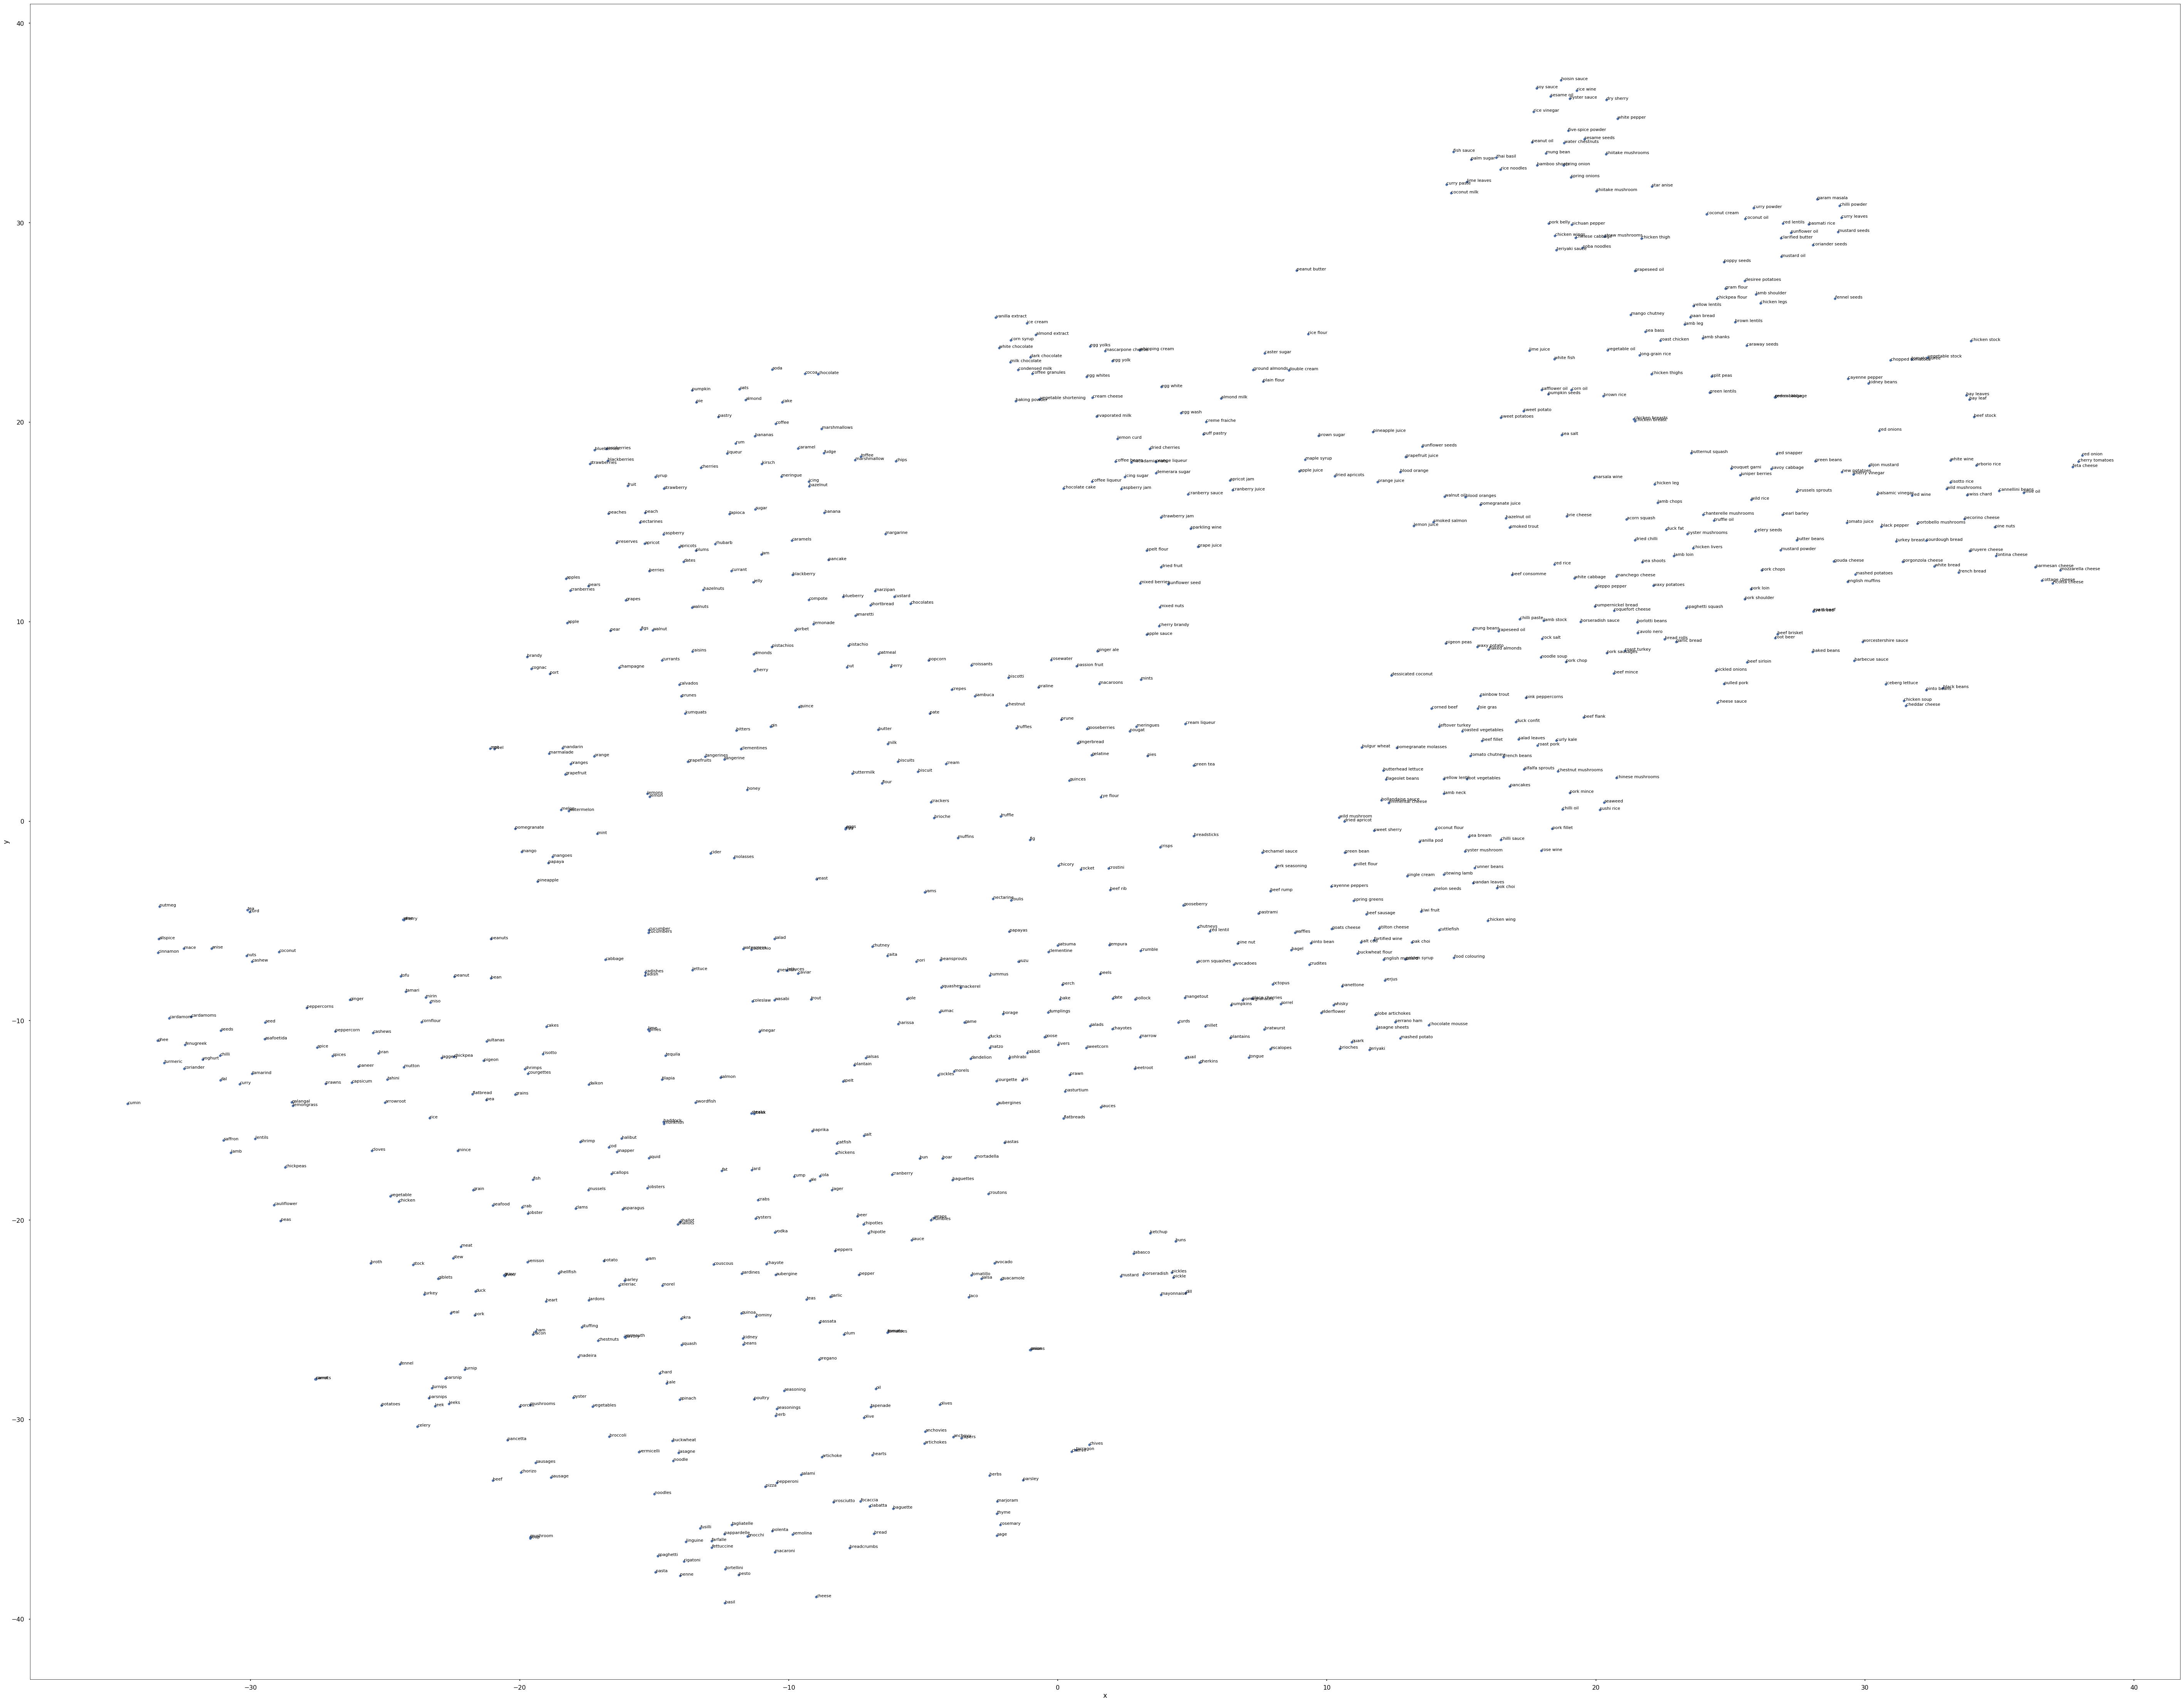

In [98]:
sns.set_context("poster")
plt.show()

In [130]:
sim_df.to_csv('word2vec_ingredient_similarity.csv',encoding='utf-8')

In [53]:
df = pd.read_csv('word2vec_ingredient_similarity.csv')
df = df.sort_values('Word2Vec Value',ascending=False)
top_df = df.groupby('Ingredient').head(5)
top_df.to_csv('word2vec_ingredient_similarity_top.csv')

In [131]:
model.most_similar('pasta')

[('penne', 0.9590814113616943),
 ('spaghetti', 0.9416716694831848),
 ('linguine', 0.9220454692840576),
 ('rigatoni', 0.916301965713501),
 ('fettuccine', 0.9087874889373779),
 ('farfalle', 0.9056376218795776),
 ('fusilli', 0.8975867033004761),
 ('tortellini', 0.882925271987915),
 ('pappardelle', 0.8654370307922363),
 ('gnocchi', 0.8619433641433716)]

In [15]:
#testing word2vec model for a few ingredients
model.most_similar('pasta')

[('penne', 0.9594287872314453),
 ('spaghetti', 0.942686915397644),
 ('linguine', 0.9211466312408447),
 ('rigatoni', 0.9150171279907227),
 ('fettuccine', 0.9088612198829651),
 ('farfalle', 0.9034274816513062),
 ('fusilli', 0.897382378578186),
 ('tortellini', 0.8817697763442993),
 ('pappardelle', 0.865876317024231),
 ('gnocchi', 0.862999439239502)]

In [16]:
model.most_similar('garlic')

[('pepper', 0.7167266607284546),
 ('squash', 0.7161271572113037),
 ('tomatoes', 0.7155648469924927),
 ('oregano', 0.7111022472381592),
 ('passata', 0.7034057378768921),
 ('peppers', 0.6969969272613525),
 ('tomato', 0.6827003359794617),
 ('okra', 0.675969123840332),
 ('mushrooms', 0.6729041934013367),
 ('capsicum', 0.6681057214736938)]

In [17]:
model.most_similar('salad')

[('radicchio', 0.8760936260223389),
 ('cucumbers', 0.8749858140945435),
 ('watercress', 0.8504606485366821),
 ('cucumber', 0.8452406525611877),
 ('lettuce', 0.8432185649871826),
 ('cherry', 0.8193576335906982),
 ('coleslaw', 0.807462215423584),
 ('radishes', 0.7977558374404907),
 ('pickles', 0.7883802652359009),
 ('pickle', 0.7810627222061157)]

In [18]:
model.most_similar('ketchup')

[('molasses', 0.8674213886260986),
 ('buns', 0.8409886360168457),
 ('tabasco', 0.8273692727088928),
 ('mustard', 0.8204975128173828),
 ('horseradish', 0.8103197813034058),
 ('mayonnaise', 0.784656286239624),
 ('pickles', 0.7645259499549866),
 ('coleslaw', 0.7525122761726379),
 ('beer', 0.7235803604125977),
 ('pickle', 0.712259829044342)]

In [19]:
model.most_similar('beef')

[('chorizo', 0.8712179660797119),
 ('turkey', 0.8632494211196899),
 ('duck', 0.8323938250541687),
 ('chicken', 0.8261815309524536),
 ('pork', 0.8165991306304932),
 ('veal', 0.8127912282943726),
 ('lard', 0.7996427416801453),
 ('sausages', 0.7868359088897705),
 ('sausage', 0.7849432826042175),
 ('gravy', 0.7849034070968628)]

In [20]:
model.most_similar('chilli')

[('tamarind', 0.9646217823028564),
 ('yoghurt', 0.9534106850624084),
 ('fenugreek', 0.9464113712310791),
 ('curry', 0.940024733543396),
 ('turmeric', 0.9308570623397827),
 ('coriander', 0.9228981137275696),
 ('spices', 0.913718581199646),
 ('dal', 0.9110320806503296),
 ('asafoetida', 0.9052260518074036),
 ('ghee', 0.9018307328224182)]

In [21]:
model.most_similar('chocolate cake')

[('praline', 0.9922243356704712),
 ('macadamia nuts', 0.9859434366226196),
 ('chocolates', 0.985792875289917),
 ('icing sugar', 0.9840693473815918),
 ('coffee beans', 0.9765180349349976),
 ('custard', 0.9724372625350952),
 ('coffee liqueur', 0.972169041633606),
 ('sambuca', 0.9715709686279297),
 ('raspberry jam', 0.9712164998054504),
 ('spelt flour', 0.970760703086853)]

In [22]:
model.most_similar('lemon')

[('lemons', 0.9219198226928711),
 ('orange', 0.8503161668777466),
 ('peel', 0.7795619368553162),
 ('artichokes', 0.7749378085136414),
 ('halibut', 0.7651411294937134),
 ('zest', 0.7277075052261353),
 ('grapefruit', 0.7124464511871338),
 ('oranges', 0.6925441026687622),
 ('herbs', 0.6820508241653442),
 ('cod', 0.6813312768936157)]

In [23]:
model.most_similar('garam masala')

[('chilli powder', 0.9621841311454773),
 ('basmati rice', 0.9560859203338623),
 ('curry leaves', 0.9422885775566101),
 ('red lentils', 0.9409244060516357),
 ('clarified butter', 0.940019965171814),
 ('mustard seeds', 0.9344639182090759),
 ('coriander seeds', 0.926223635673523),
 ('curry powder', 0.9261242151260376),
 ('mustard oil', 0.923936128616333),
 ('sunflower oil', 0.9237058758735657)]

In [24]:
model.most_similar('coconut oil')

[('curry powder', 0.9683756828308105),
 ('clarified butter', 0.9650747776031494),
 ('red lentils', 0.9554360508918762),
 ('sunflower oil', 0.9415408968925476),
 ('coconut milk', 0.9312362670898438),
 ('basmati rice', 0.9283173084259033),
 ('lime leaves', 0.922572135925293),
 ('curry paste', 0.9215974807739258),
 ('coconut cream', 0.9140549898147583),
 ('chilli powder', 0.9136563539505005)]

In [25]:
model.most_similar('almond milk')

[('ground almonds', 0.9817588925361633),
 ('coffee beans', 0.9816960096359253),
 ('raspberry jam', 0.9780769944190979),
 ('coffee liqueur', 0.9779437780380249),
 ('lemon curd', 0.9771873354911804),
 ('apple sauce', 0.9763165712356567),
 ('egg wash', 0.9758636951446533),
 ('icing sugar', 0.9741314649581909),
 ('strawberry jam', 0.9722164869308472),
 ('demerara sugar', 0.9719484448432922)]

In [26]:
model.most_similar('bread')

[('ciabatta', 0.9062380790710449),
 ('breadcrumbs', 0.8974777460098267),
 ('focaccia', 0.869843602180481),
 ('polenta', 0.8395727872848511),
 ('pizza', 0.8370962142944336),
 ('prosciutto', 0.8320060968399048),
 ('baguette', 0.8181380033493042),
 ('macaroni', 0.8031692504882812),
 ('semolina', 0.7940359115600586),
 ('herb', 0.7927338480949402)]

In [27]:
model.most_similar('cumin')

[('paprika', 0.8218393325805664),
 ('coriander', 0.8128418326377869),
 ('turmeric', 0.8066155314445496),
 ('chipotle', 0.8020739555358887),
 ('fenugreek', 0.7961008548736572),
 ('beer', 0.773319661617279),
 ('chilli', 0.7730795741081238),
 ('yoghurt', 0.7608011364936829),
 ('cardamom', 0.7586836814880371),
 ('seeds', 0.7499501705169678)]

In [28]:
model.most_similar('egg')

[('eggs', 0.8828203082084656),
 ('semolina', 0.8700793981552124),
 ('breadcrumbs', 0.8307029008865356),
 ('yeast', 0.8147512674331665),
 ('milk', 0.7837612628936768),
 ('flour', 0.7715761065483093),
 ('macaroni', 0.7672526240348816),
 ('buttermilk', 0.7555316686630249),
 ('polenta', 0.7501257061958313),
 ('vodka', 0.7447409629821777)]

In [29]:
model.most_similar('rice')

[('grain', 0.8520363569259644),
 ('tofu', 0.8518105745315552),
 ('prawns', 0.8329977989196777),
 ('quinoa', 0.832108736038208),
 ('vermicelli', 0.7784930467605591),
 ('fish', 0.7504971027374268),
 ('bran', 0.7485853433609009),
 ('peas', 0.7467087507247925),
 ('peanut', 0.745407223701477),
 ('lemongrass', 0.7417622804641724)]

In [30]:
model.most_similar('milk chocolate')

[('white chocolate', 0.9970255494117737),
 ('dark chocolate', 0.9881919026374817),
 ('condensed milk', 0.9852464199066162),
 ('corn syrup', 0.9797650575637817),
 ('coffee granules', 0.9781382083892822),
 ('vegetable shortening', 0.9683545827865601),
 ('almond extract', 0.9633331894874573),
 ('coffee beans', 0.9612351655960083),
 ('ice cream', 0.961205244064331),
 ('coffee liqueur', 0.9604560136795044)]

In [31]:
model.most_similar('mushrooms')

[('porcini', 0.907909095287323),
 ('squash', 0.9059662818908691),
 ('okra', 0.873516321182251),
 ('chard', 0.8721720576286316),
 ('leek', 0.8674924373626709),
 ('asparagus', 0.8539893627166748),
 ('leeks', 0.8532019853591919),
 ('kale', 0.8441998958587646),
 ('pancetta', 0.8383700251579285),
 ('broccoli', 0.8368805646896362)]

#Tfidf Implementation to identify the importance of an ingredient

In [19]:
#Create a dictionary for all the ingredients in the recipe list

dictionary = corpora.Dictionary(ingr_list)
#print(dictionary)
#print(dictionary.token2id)
print dictionary.token2id

{u'chillis': 539, u'red cabbage': 431, u'pheasant': 981, u'dijon mustard': 57, u'mixed nuts': 803, u'macadamia nuts': 122, u'smoked fish': 1034, u'mackerel': 857, u'ale': 490, u'courgettes': 645, u'mortadella': 776, u'grape juice': 378, u'sweet potatoes': 275, u'morel': 678, u'porcini': 21, u'passion fruit': 826, u'milk': 29, u'comte cheese': 825, u'preserves': 455, u'blueberries': 177, u'clementines': 720, u'pineapple juice': 660, u'lamb racks': 962, u'fusilli': 578, u'peanut': 251, u'pork shoulder': 253, u'cayenne pepper': 159, u'celery seeds': 279, u'pancetta': 307, u'curds': 582, u'mozzarella cheese': 70, u'couscous': 632, u'white bread': 117, u'whisky': 715, u'bechamel sauce': 756, u'caraway seeds': 386, u'langoustines': 952, u'turnips': 596, u'beetroots': 997, u'vanilla extract': 124, u'yeast': 241, u'ginger ale': 704, u'root beer': 677, u'fat': 6, u'mince': 393, u'emmental cheese': 903, u'figs': 493, u'quince': 381, u'chocolate cake': 607, u'poultry': 497, u'sparkling wine': 371

In [18]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1)]

In [23]:
# train the model
tfidf = models.TfidfModel(bow_corpus)

In [24]:
corpus_tfidf = tfidf[bow_corpus]

In [89]:
#print corpus for the first recipe
for i in corpus_tfidf:
    print i
    break

[(0, 0.13418040113622748), (1, 0.10172573177525686), (2, 0.18249677540349668), (3, 0.23757050937580798), (4, 0.30484697633622604), (5, 0.19234683342529355), (6, 0.3229189640188071), (7, 0.26940187443482694), (8, 0.4306925549644671), (9, 0.46811917124540176), (10, 0.3064858484678542), (11, 0.27668475600498216)]


In [81]:
#print tfidf results for the first recipe
print(tfidf[bow_corpus[1]])

[(2, 0.13591610083534908), (6, 0.48099355594844895), (12, 0.17141189065331253), (13, 0.31664890813217206), (14, 0.4221632275315159), (15, 0.3648792645906537), (16, 0.3638872913434028), (17, 0.2056974689420348), (18, 0.1144220582258819), (19, 0.34834890561627124)]


In [ ]:
#Use similarities library from gensim to get the cosine similarity of the tfidf results

index = similarities.MatrixSimilarity(tfidf[bow_corpus])
index.save('ingr.index')
index = similarities.MatrixSimilarity.load('ingr.index')

sims = index[corpus_tfidf]
sims_list = [(i,j) for i,j in enumerate(sims)]

#Creating a list to hold the cosine similarity results for tfidf
tf_idf_list = []

for i,j in enumerate(sims_list):
    tf_idf_list.append(sims_list[i][1])

In [175]:
#Create recipe dict- to be used in creating dataframe in next step - used to decode recipe id
recipe_dict =  {k: v for k, v in enumerate(train.name)}
recipe_dict

{0: u'Mushroom Risotto',
 1: u'Filipino BBQ Pork Skewers',
 2: u'Mushroom and Roasted Garlic Risotto',
 3: u'Gratin Dauphinois (Scalloped Potatoes with Cheese)',
 4: u'Delicious Grilled Hamburgers',
 5: u'Hickory-Smoked Bourbon Turkey',
 6: u'Marinated Beef Tenderloin',
 7: u'Cherry Tortoni',
 8: u'Crock-Pot Italian Turkey Meatballs and Homemade Sauce',
 9: u'Chicken Salad with Wild Rice',
 10: u'Beet and Carrot Slaw',
 11: u'Crab-and-Shrimp E\u0301touffe\u0301e',
 12: u'N.I.K \u2013 Italian Meatballs & Spaghetti',
 13: u'Mozzarella Omelet with Sage and Red Chile Flakes',
 14: u'Sticky Chinese Pork Belly',
 15: u"John Legend's Macaroni and Cheese",
 16: u'Arizona Tortilla Soup',
 17: u'Stuart\u2019s Thai Green Curry',
 18: u'Western Waldorf',
 19: u'Salsa Verde',
 20: u'Red Lentil Curry With Black Tahini and Roasted Cashews [Vegan, Gluten-Free]',
 21: u'Spaghetti and Meatballs',
 22: u'Black-Eyed Pea Cakes',
 23: u'Macadamia Nut-Chocolate Tarts',
 24: u'White Bean Dip',
 25: u'Roast Tu

In [183]:
#Use cosine similarity results to get the top 10 similar recipes for every recipe.
tf_idf_top  = []
similar_recipes_df = pd.DataFrame([])
same_item = []

#Get only top 11 largest values from the tf_idf_list - 1 recipe will be the same as itself (hence 12)
for i,item in enumerate(tf_idf_list):
    tf_idf_top.append(heapq.nlargest(11,enumerate(item), key=lambda x: x[1]))

#Remove the recipe value with 1.0 similarity - since it is the same recipe
for i,list_item in enumerate(tf_idf_top):
    for j,k in enumerate(list_item):
        if tf_idf_top[i][j][1] != 1.0:
            similar_recipes_df = similar_recipes_df.append(pd.DataFrame({'Similar_Recipe_ID': recipe_dict.get(tf_idf_top[i][j][0]),'TF-IDF Value': tf_idf_top[i][j][1],'Recipe_ID': recipe_dict.get(i)}, index=[0]), ignore_index=True)

In [187]:
similar_recipes_df.to_csv('similar_recipes_top_10_tf_idf.csv',encoding='utf-8')

In [19]:
similar_recipes_df = pd.read_csv('similar_recipes_top_10_tf_idf.csv')
similar_recipes_df = similar_recipes_df[similar_recipes_df['Recipe_ID'] != similar_recipes_df['Similar_Recipe_ID']]
print similar_recipes_df.count()

Unnamed: 0           270592
Recipe_ID            270592
Similar_Recipe_ID    270592
TF-IDF Value         270592
dtype: int64


In [20]:
similar_recipes_df

,Unnamed: 0,Recipe_ID,Similar_Recipe_ID,TF-IDF Value
0,0,Mushroom Risotto,Collard Greens and Italian Sausage Risotto,0.672957
1,1,Mushroom Risotto,Shiitake and Baby Bella Mushroom Risotto,0.640316
2,2,Mushroom Risotto,Parmesan Risotto with Pesto,0.634761
3,3,Mushroom Risotto,Risotto alla Milanese,0.572591
4,4,Mushroom Risotto,Risotto with Sun-Dried Tomatoes and Mozzarella,0.572418
5,5,Mushroom Risotto,Parmesan Risotto,0.552064
6,6,Mushroom Risotto,White Risotto,0.550371
7,7,Mushroom Risotto,Ratatouille Risotto,0.547907
8,8,Mushroom Risotto,Baked Sausage and Mushroom Risotto,0.535712
11,11,Filipino BBQ Pork Skewers,Dynamite Bourbon Ribs,0.688809


In [21]:
similar_recipes_df.to_csv('similar_recipes_tf_idf.csv',encoding='utf-8')

In [22]:
similar_recipes_df

,Unnamed: 0,Recipe_ID,Similar_Recipe_ID,TF-IDF Value
0,0,Mushroom Risotto,Collard Greens and Italian Sausage Risotto,0.672957
1,1,Mushroom Risotto,Shiitake and Baby Bella Mushroom Risotto,0.640316
2,2,Mushroom Risotto,Parmesan Risotto with Pesto,0.634761
3,3,Mushroom Risotto,Risotto alla Milanese,0.572591
4,4,Mushroom Risotto,Risotto with Sun-Dried Tomatoes and Mozzarella,0.572418
5,5,Mushroom Risotto,Parmesan Risotto,0.552064
6,6,Mushroom Risotto,White Risotto,0.550371
7,7,Mushroom Risotto,Ratatouille Risotto,0.547907
8,8,Mushroom Risotto,Baked Sausage and Mushroom Risotto,0.535712
11,11,Filipino BBQ Pork Skewers,Dynamite Bourbon Ribs,0.688809


In [53]:
#Create cosine similarity matrix for all recipes 27637*27637
#Since this is a huge matrix, the top 10 similar recipe logic is a better option.

names = [i for i in range(1,len(tf_idf_list))]
final_df = pd.DataFrame.from_items(zip(names,tf_idf_list))

In [54]:
final_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27628,27629,27630,27631,27632,27633,27634,27635,27636,27637
0,1.000000,0.180126,0.358633,0.041558,0.022843,0.015639,0.043783,0.000000,0.124680,0.0,...,0.023780,0.013000,0.070168,0.100737,0.000000,0.095806,0.134180,0.0,0.029333,0.019996
1,0.180126,1.000000,0.025076,0.085856,0.019403,0.263479,0.139691,0.000000,0.058509,0.0,...,0.018664,0.191756,0.060680,0.071113,0.094724,0.029465,0.000000,0.0,0.000000,0.090478
2,0.358633,0.025076,1.000000,0.076052,0.029736,0.010391,0.008204,0.002939,0.076479,0.0,...,0.009648,0.046064,0.012467,0.069755,0.000000,0.014265,0.000000,0.0,0.004099,0.002794
3,0.041558,0.085856,0.076052,1.000000,0.049082,0.008090,0.080590,0.010063,0.097211,0.0,...,0.011996,0.346200,0.062795,0.156891,0.000000,0.020465,0.309716,0.0,0.081741,0.172275
4,0.022843,0.019403,0.029736,0.049082,1.000000,0.007737,0.543439,0.009623,0.069814,0.0,...,0.078339,0.045061,0.040820,0.044083,0.000000,0.046707,0.000000,0.0,0.013421,0.009149


In [ ]:
train['recipe_id'] = train.index
recipe_name_df = train[['recipe_id','name']]
final_df['recipe_id'] = final_df.index

recipe_tf_idf_df = final_df.merge(recipe_name_df,how='left', left_on='recipe_id', right_on='recipe_id')

In [87]:
recipe_tf_idf_df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,27630,27631,27632,27633,27634,27635,27636,27637,recipe_id,name
0,1.000000,0.180126,0.358633,0.041558,0.022843,0.015639,0.043783,0.000000,0.124680,0.0,...,0.070168,0.100737,0.000000,0.095806,0.134180,0.0,0.029333,0.019996,0,Mushroom Risotto
1,0.180126,1.000000,0.025076,0.085856,0.019403,0.263479,0.139691,0.000000,0.058509,0.0,...,0.060680,0.071113,0.094724,0.029465,0.000000,0.0,0.000000,0.090478,1,Filipino BBQ Pork Skewers
2,0.358633,0.025076,1.000000,0.076052,0.029736,0.010391,0.008204,0.002939,0.076479,0.0,...,0.012467,0.069755,0.000000,0.014265,0.000000,0.0,0.004099,0.002794,2,Mushroom and Roasted Garlic Risotto
3,0.041558,0.085856,0.076052,1.000000,0.049082,0.008090,0.080590,0.010063,0.097211,0.0,...,0.062795,0.156891,0.000000,0.020465,0.309716,0.0,0.081741,0.172275,3,Gratin Dauphinois (Scalloped Potatoes with Che...
4,0.022843,0.019403,0.029736,0.049082,1.000000,0.007737,0.543439,0.009623,0.069814,0.0,...,0.040820,0.044083,0.000000,0.046707,0.000000,0.0,0.013421,0.009149,4,Delicious Grilled Hamburgers


In [25]:
#Create a list from tfidf results
#This will be used to identify ingredient importance within every recipe

corpus_list = []
for doc in corpus_tfidf:
    corpus_list.append(doc)

In [26]:
corpus_list[0]

[(0, 0.13418040113622748),
 (1, 0.10172573177525686),
 (2, 0.18249677540349668),
 (3, 0.23757050937580798),
 (4, 0.30484697633622604),
 (5, 0.19234683342529355),
 (6, 0.3229189640188071),
 (7, 0.26940187443482694),
 (8, 0.4306925549644671),
 (9, 0.46811917124540176),
 (10, 0.3064858484678542),
 (11, 0.27668475600498216)]

In [9]:
#Create a flat list to eliminate repetition of ingredients and create a dict to hold the results

flat_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flat_list:
            flat_list.append(item)
ing_dict =  {k: v for k, v in enumerate(flat_list)}

In [11]:
len(ing_dict)

1048

In [28]:
dictionary.get(corpus_list[0][0][0])

u'butter'

In [34]:
#Create a dataframe with tf-idf values per ingredient for every recipe.
corpus_df = pd.DataFrame([])

for i,list_item in enumerate(corpus_list):
    for j,k in enumerate(list_item):
        corpus_df = corpus_df.append(pd.DataFrame({'Ingredient': dictionary.get(corpus_list[i][j][0]),'TF-IDF Value': corpus_list[i][j][1],'Recipe_ID': i}, index=[0]), ignore_index=True)

In [35]:
corpus_df.to_csv('ingredient_tf_idf.csv')

In [38]:
train['recipe_id'] = train.index
recipe_tf_idf_df = corpus_df.merge(train,how='left', left_on='Recipe_ID', right_on='recipe_id')
recipe_tf_idf_df = recipe_tf_idf_df[['Recipe_ID','name','Ingredient','TF-IDF Value']]
recipe_tf_idf_df.head(20)


,Recipe_ID,name,Ingredient,TF-IDF Value
0,0,Mushroom Risotto,butter,0.134180
1,0,Mushroom Risotto,olive oil,0.101726
2,0,Mushroom Risotto,pepper,0.182497
3,0,Mushroom Risotto,parmesan cheese,0.237571
4,0,Mushroom Risotto,chicken stock,0.304847
5,0,Mushroom Risotto,parsley,0.192347
6,0,Mushroom Risotto,fat,0.322919
7,0,Mushroom Risotto,white wine,0.269402
8,0,Mushroom Risotto,vegetable stock,0.430693
9,0,Mushroom Risotto,arborio rice,0.468119


In [39]:
recipe_tf_idf_df.to_csv('ingredient_recipe_tf_idf.csv',encoding='utf-8')